In [43]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

In [44]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", attn_implementation="sdpa")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [45]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

images = [image, image, image, image, image]


In [46]:
text = ["a photo of a cat", "a photo of a dog", "a photo of a remote controller", "a photo of two cute cats"]
inputs = processor(text=text, images=images, return_tensors="pt", padding=True)

In [47]:
inputs["pixel_values"].shape, inputs["input_ids"].shape, inputs["attention_mask"].shape

(torch.Size([5, 3, 224, 224]), torch.Size([4, 8]), torch.Size([4, 8]))

In [48]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [49]:
logits_per_image.shape, probs.shape

(torch.Size([5, 4]), torch.Size([5, 4]))

In [50]:
import matplotlib.pyplot as plt
import numpy as np


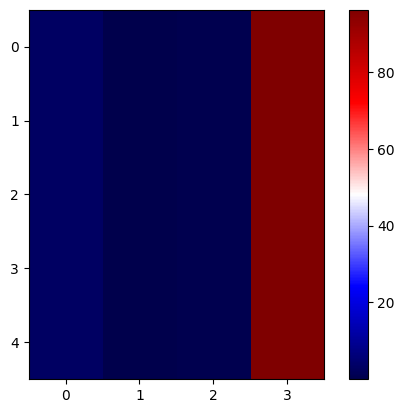

In [51]:
plt.imshow(100*probs.detach().numpy(), cmap="seismic")
plt.colorbar()

In [52]:
}plt.imshow(np.array(image))
plt.title(text[0])

SyntaxError: unmatched '}' (1438563636.py, line 1)

In [53]:
import torch

model.to("cuda")

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [70]:
device = "cpu"
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [54]:
torch. cuda. get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3050 4GB Laptop GPU', major=8, minor=6, total_memory=3801MB, multi_processor_count=20, uuid=87e3abde-eb07-aee8-4d8a-d5db8b976f6e, L2_cache_size=1MB)

In [55]:
from src.lib.dataset.ROCODataset import ImageTextDataset

In [56]:
import yaml
cfg = yaml.safe_load(open("/home/felipe/Projects/roco-image-captioning/config.yaml"))
from pprint import pprint
pprint(cfg)

{'dataset': {'test_json': '/home/felipe/Projects/roco-image-captioning/roco-dataset/json/test_dataset.json',
             'train_json': '/home/felipe/Projects/roco-image-captioning/roco-dataset/json/train_dataset.json',
             'validation_json': '/home/felipe/Projects/roco-image-captioning/roco-dataset/json/validation_dataset.json'},
 'input_size': [224, 224],
 'optimizer': {'lr': 0.0001,
               'lr_scheduler_rate': 0.1,
               'method': 'adam',
               'weight_decay': 0.0},
 'registry': {'checkpoints_dir': 'outputs/model_checkpoints',
              'name': 'roco-clip',
              'project': 'roco-debug',
              'wandb_root_dir': 'outputs/wandb_outputs'},
 'train': {'batch_size': 4,
           'early_stopping_patience': 5,
           'gradient_clip_val': 100.0,
           'limit_train_batches': 0.1,
           'log_every_n_steps': 4,
           'max_epochs': 10,
           'max_seq_length': 70}}


In [57]:
train_dataset = ImageTextDataset(
    name="train",
    cfg=cfg,
    root="/home/felipe/Projects/roco-image-captioning",
)

val_dataset = ImageTextDataset(
    name="val",
    cfg=cfg,
    root="/home/felipe/Projects/roco-image-captioning",
)

In [58]:
len(train_dataset), len(val_dataset)

(65391, 8169)

In [59]:
from torch.utils.data import DataLoader
from tqdm import tqdm

In [60]:
batch_size = 4
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [61]:
import torch

In [71]:
def process_text_and_images(images, targets):
    inputs = processor(text=targets, images=images, return_tensors="pt", padding=True)
    return inputs    
    
def create_pairs(images, targets):
    size = images.shape[0]
    print(type(images), type(targets), images.shape, len(targets), targets)
    
    
    positive_pairs = process_text_and_images(images, targets)
    
    negative_pairs = []
    for i in range(size):
        for j in range(size):
            if i == j:
                continue
            pass    
            
    
    
    
    processed = process_text_and_images(images, targets)
    
    print(processed["pixel_values"].shape, processed["input_ids"].shape)
    
    pairs = {"input_ids": [], "attention_mask": [], "pixel_values": []}
    labels = []
    
    for i in range(size):
        for j in range(size):
            
            # build every possible image / text pair
            pairs["input_ids"].append(processed["input_ids"][i])  
            pairs["attention_mask"].append(processed["attention_mask"][i])  # masks padding added to text
            pairs["pixel_values"].append(processed["pixel_values"][j])
           
            # labels for contrastive learning            
            if i == j:  # positive sample
                labels.append(1)
            else:  # negative sample
                labels.append(0)
    
    # convert to tensor
    for k, v in pairs.items():
        pairs[k] = torch.stack(v, dim=0)
    labels = torch.tensor(labels, dtype=torch.float32)
    return pairs, labels

In [85]:
model.train()
for batch in train_dl:
    images = batch[0]
    targets = batch[1]
    inputs = processor(text=targets, images=images, return_tensors="pt", padding=True)
    
    outputs = model(**inputs)
    
    logits_per_image = outputs.logits_per_image
    logits_per_text = outputs.logits_per_text
    
    print(logits_per_image.shape, logits_per_text.shape)
    print(logits_per_text.softmax(dim=1))
    print(logits_per_text.softmax(dim=1).argmax(dim=1))
    print(torch.nn.functional.one_hot(logits_per_text.softmax(dim=1).argmax(dim=1), num_classes=logits_per_text.shape[-1]))
    
    print(targets)
    break

    # pairs, labels = create_pairs(image, target)
    # 
    # break
    # for k in pairs:
    #     pairs[k] = pairs[k].to(device)    
    # 
    # text_features = model.get_text_features(input_ids=pairs["input_ids"],
    #                                         attention_mask=pairs["attention_mask"],)
    # image_features = model.get_image_features(pixel_values=pairs["pixel_values"],)    


torch.Size([4, 4]) torch.Size([4, 4])
tensor([[0.3465, 0.1196, 0.2388, 0.2952],
        [0.3178, 0.1364, 0.2258, 0.3200],
        [0.2980, 0.1723, 0.2513, 0.2785],
        [0.2468, 0.2133, 0.2464, 0.2935]], grad_fn=<SoftmaxBackward0>)
tensor([0, 3, 0, 3])
tensor([[1, 0, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 0, 1]])
(' Left ventriculography. Right anterior oblique, 30° view of grade 3 to', " Bowen's Disease, OCT aspect. E: epidermis, which in the lesional area", ' Normal left anterior descending (LAD) and right coronary (RCA) arteri', ' Post-reduction radiograph of the wrist. Mild shortening of radial len')


In [13]:
|import einops

In [14]:
def scaled_pairwise_cosine_sim_loss(text_features, image_features, labels, weight=0.5):
    text_logits = torch.bmm(einops.rearrange(text_features, "b d -> b 1 d"),
                            einops.rearrange(image_features, "b d -> b d 1"))
    
    image_logits = torch.bmm(einops.rearrange(image_features, "b d -> b 1 d"),
                             einops.rearrange(image_features, "b d -> b d 1"))
    
    text_logits = einops.rearrange(text_logits, "b 1 1 -> b")
    image_logits = einops.rearrange(image_logits, "b 1 1 -> b")
    
    normalization = torch.linalg.vector_norm(text_features, dim=1) * torch.linalg.norm(image_features, dim=1)
    
    text_logits /= normalization
    image_logits /= normalization
    
    text_logits = torch.log(text_logits)
    image_logits = torch.log(image_logits)

    text_loss = torch.nn.functional.binary_cross_entropy_with_logits(
        text_logits, labels
    )
    
    image_loss = torch.nn.functional.binary_cross_entropy_with_logits(
        image_logits, labels
    )
    
    return weight * text_loss + (1 - weight) * image_loss
            

In [15]:
loss_fn = scaled_pairwise_cosine_sim_loss
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
lr_schedule = torch.optim.lr_scheduler.LinearLR(optimizer)

In [16]:
model.train()
pbar = tqdm(total=len(train_dataset), desc="Training")
for batch in train_dl:
    image = batch[0]
    target = batch[1]
    pairs, labels = create_pairs(image, target)
    for k in pairs:
        pairs[k] = pairs[k].to(device)    
    
    text_features = model.get_text_features(input_ids=pairs["input_ids"],
                                            attention_mask=pairs["attention_mask"],)
    image_features = model.get_image_features(pixel_values=pairs["pixel_values"],)    

    loss = loss_fn(text_features, image_features, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_schedule.step()

    pbar.set_description(f"Training: loss = {loss.item()}")
    pbar.update()

Training: loss = 0.5623372793197632:   0%|          | 34/65397 [01:35<39:26:46,  2.17s/it]

KeyboardInterrupt: 

In [22]:
shaps = set()
for batch in train_dl:
    image = batch[0]
    shaps.add(image.shape)

Corrupt JPEG data: premature end of data segment


RuntimeError: Unsupported JPEG process: SOF type 0xc6

TypeError: unsupported operand type(s) for +=: 'set' and 'int'

In [2]:
from src.lib.dataset.CLIP_ROCODataset import CLIPDataset

ModuleNotFoundError: No module named 'ROCODataset'

In [ ]:
train_dataset = ImageTextDataset(
    name="train",
    cfg=cfg,
    root="/home/felipe/Projects/roco-image-captioning",
)

val_dataset = ImageTextDataset(
    name="val",
    cfg=cfg,
    root="/home/felipe/Projects/roco-image-captioning",
)